In [2]:
import clip
import torch
import pandas as pd
import numpy as np

from pathlib import Path
import os

from dataset import MyDataset

In [3]:
data_path = "/opt/ml/MS-COCO/val2017"
label_path = "/opt/ml/MS-COCO/annotations/eng_re_translated_captions_val2017_3.json"

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

def viz_img(image_idx):
    fig = plt.figure(figsize=(10,12))
    rows = 5
    cols = 6
    
    BASE_PATH = '/opt/ml/MS-COCO/val2017/'
    for idx, i in enumerate(image_idx[0]):
        # batch_size 1로 설정해도 총 5 caption에 대한 각 30개의 이미지들이 나옴
        num = 12 - len(str(i))
        file_name = os.path.join(BASE_PATH, f'{"0"*num}{i}.jpg')
        
        ax_name = "ax" + str(idx)
        ax_name = fig.add_subplot(rows, cols, idx+1)
        ax_name.grid(False)
        ax_name.set_xticks([])
        ax_name.set_yticks([])
        ax_name.imshow(Image.open(file_name))
        
    fig.tight_layout()
    plt.show()

### MoTIS

In [5]:
# Load the open CLIP model
device = "cpu"
_, preprocess = clip.load("ViT-B/32", device=device)

vision_model = torch.jit.load("./weights/motis/final_visual.pt").to(device).eval()  # Vision Transformer
text_model = torch.jit.load("./weights/motis/final_text_encoder_4.pt").to(device).eval()  # Text Transformer

# Load the photo IDs
feature_path = Path("/opt/ml/level3_cv_finalproject-cv-19/COCO-benchmarking/feature_store") / 'motis'


photo_ids = pd.read_csv(os.path.join(feature_path, "photo_ids.csv"))
photo_ids = list(photo_ids["photo_id"])

# Load the features vectors
photo_features = np.load(os.path.join(feature_path, "features.npy"))

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
    photo_features = torch.from_numpy(photo_features).float().to(device)
else:
    photo_features = torch.from_numpy(photo_features).to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

dataset = MyDataset(label_path, data_path, preprocess)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, collate_fn=dataset.collate_fn, shuffle=True, drop_last=False
)

Photos loaded: 5000
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


A very old toilet and sink in an old room


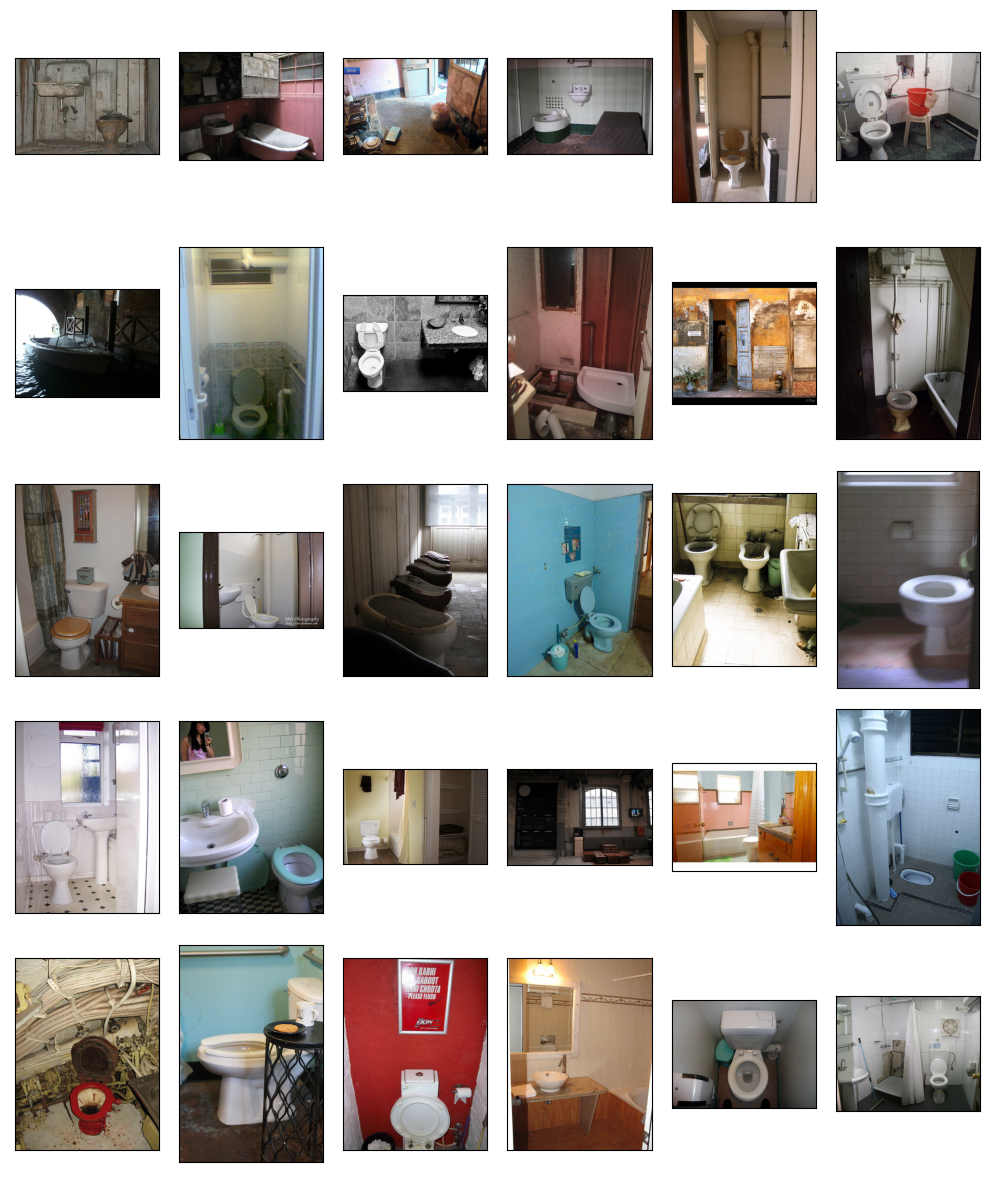

In [6]:
target, captions = next(iter(dataloader))

# Encode and normalize the search query using CLIP
text_encoded = text_model(clip.tokenize(captions[0]).to(device))  # torch.Size([5, 512])
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

# Compute the similarity between the search query and each photo using the Cosine similarity
similarities = (text_encoded @ photo_features.T).squeeze(1)  # torch.Size([5, 5000])

# Sort the photos by their similarity score
best_photo_idx = (-similarities).argsort()

# Return the photo IDs of the best matches
best_photo_ids = [[photo_ids[j] for j in i[: 30]] for i in best_photo_idx]

print(captions[0][0])
viz_img(best_photo_ids)


### CLIP

In [7]:
# Load the open CLIP model
device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device) # "ViT-B/32" "RN50"

# Load the photo IDs
clip_feature_path = Path("/opt/ml/level3_cv_finalproject-cv-19/COCO-benchmarking/feature_store") / 'clip'


photo_ids = pd.read_csv(os.path.join(feature_path, "photo_ids.csv"))
photo_ids = list(photo_ids["photo_id"])

# Load the features vectors
photo_features = np.load(os.path.join(feature_path, "features.npy"))

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
photo_features = torch.from_numpy(photo_features).half().to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

dataset = MyDataset(label_path, data_path, preprocess)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, collate_fn=dataset.collate_fn, shuffle=True, drop_last=False)

Photos loaded: 5000
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


a zebra standing among the big rocks


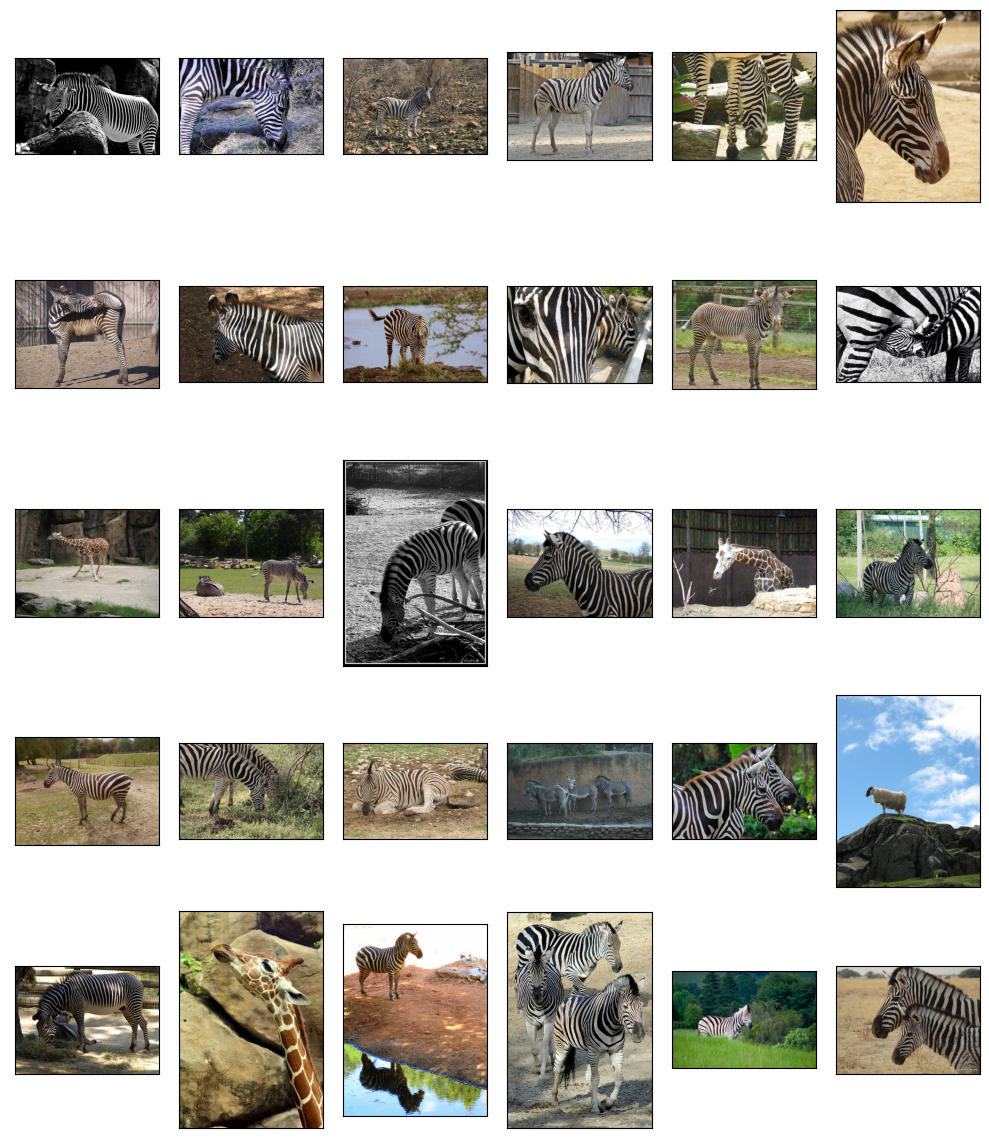

In [8]:
target, captions = next(iter(dataloader))

text_encoded = model.encode_text(clip.tokenize(captions[0]).to(device))  # torch.Size([5, 512])
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

# Compute the similarity between the search query and each photo using the Cosine similarity
similarities = (text_encoded @ photo_features.T).squeeze(1)  # torch.Size([5, 5000])

# Sort the photos by their similarity score
best_photo_idx = (-similarities).argsort()

# Return the photo IDs of the best matches
best_photo_ids = [[photo_ids[j] for j in i[: 30]] for i in best_photo_idx]

print(captions[0][0])
viz_img(best_photo_ids)


### CLIP (RN50)

In [9]:
# Load the open CLIP model
device = "cuda"
model, preprocess = clip.load("RN50", device=device) # "ViT-B/32" "RN50"

# Load the photo IDs
clip_feature_path = Path("/opt/ml/level3_cv_finalproject-cv-19/COCO-benchmarking/feature_store") / 'clip_RN50'


photo_ids = pd.read_csv(os.path.join(feature_path, "photo_ids.csv"))
photo_ids = list(photo_ids["photo_id"])

# Load the features vectors
photo_features = np.load(os.path.join(feature_path, "features.npy"))

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
photo_features = torch.from_numpy(photo_features).half().to(device)

# Print some statistics
print(f"Photos loaded: {len(photo_ids)}")

dataset = MyDataset(label_path, data_path, preprocess)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, collate_fn=dataset.collate_fn, shuffle=True, drop_last=False)

Photos loaded: 5000
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [10]:
target, captions = next(iter(dataloader))

text_encoded = model.encode_text(clip.tokenize(captions[0]).to(device))  # torch.Size([5, 512])
text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

# Compute the similarity between the search query and each photo using the Cosine similarity
similarities = (text_encoded @ photo_features.T).squeeze(1)  # torch.Size([5, 5000])

# Sort the photos by their similarity score
best_photo_idx = (-similarities).argsort()

# Return the photo IDs of the best matches
best_photo_ids = [[photo_ids[j] for j in i[: 30]] for i in best_photo_idx]

print(captions[0][0])
viz_img(best_photo_ids)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (6x1024 and 512x5000)

In [11]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f4e603324c0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)